In [1]:
import networks as n
from collections import OrderedDict
from collections import Counter
import math
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
ds = n.load_feather()
projects_list = n.create_project_list(ds)
authors_list = n.create_authors_list(projects_list)

In [5]:
ds.columns

Index(['orig_index', 'Nom de l'objet', 'Programme', 'Adresse 1', 'Adresse 2',
       'Adresse 3', 'Numéro postal', 'Localité', 'Canton - Département',
       'Pays', 'Date de début de l'objet', 'Date de fin de l'objet',
       'Concours ouvert à', 'Notes de l'objet', 'Auteurs', 'Rôle de l'auteur',
       'Dossiers reliés', 'Pièces reliées', 'CombinedArtists', 'is_jury',
       'paired_competitons', 'comp_id', 'Commune', 'Canton', 'geo_loc',
       'Auteurs_cleaned'],
      dtype='object')

In [ ]:
def shannon_entropy(counts: Counter[str]) -> float:
    """Compute Shannon entropy from a Counter of region frequencies."""
    total = sum(counts.values())
    if total == 0:
        return 0.0
    entropy = 0.0
    for count in counts.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

def compute_entropy_per_author(authors: list[n.Author], mergeGEandVD = False) -> dict[str, float]:
    """Returns a mapping of author name to Shannon entropy based on canton distribution."""
    entropy_map = {}
    for author in authors:
        canton_counts = Counter(project.canton if (not mergeGEandVD) or (project.canton != "GE" and project.canton != "VD") else "GE or VD"  for project in author.projects)
        entropy = shannon_entropy(canton_counts)
        entropy_map[author.name_abr] = entropy
    return entropy_map

def get_year_and_maxcanton(author: n.Author, mergeGEandVD = False):
    mean_year = 0
    year_count = 0
    for project in author.projects:
        if project.year < 2000:
            mean_year += project.year
            year_count += 1
    mean_year = (mean_year / year_count) if year_count else 2020

    cantons = {}
    for project in author.projects:
        if mergeGEandVD and (project.canton == "GE" or project.canton == "VD"):
            cantons["GE or VD"] = cantons.get("GE or VD", 0) + 1
        else:
            cantons[project.canton] = cantons.get(project.canton, 0) + 1
    max_canton = max(cantons, key=cantons.get)

    return mean_year, max_canton

# Plotting function
def plot_entropy_vs_birth(authors: list[n.Author], mergeGEandVD = False):
    entropy_map = compute_entropy_per_author(authors, mergeGEandVD)
    authors = [author for author in authors if len(author.projects) > 5]
    y = [entropy_map[author.name_abr] for author in authors]
    x = [get_year_and_maxcanton(author, mergeGEandVD)[0] for author in authors]
    sizes = [max(30, len(author.projects) * 10) for author in authors]  # Scale bubble size
    colors = [get_year_and_maxcanton(author, mergeGEandVD)[1] for author in authors]
    labels = [author.name_abr for author in authors]

    # Assign colors
    unique_regions = list(set(colors))
    region_colors = {region: f"C{idx}" for idx, region in enumerate(unique_regions)}
    color_values = [region_colors[region] for region in colors]

    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(x, y, s=sizes, c=color_values, alpha=0.7, edgecolor='black')

    #Add labels near bubbles
    # for i, label in enumerate(labels):
    #     if len(authors[i].projects) > 16:
    #         plt.text(x[i] + 0.02, y[i], label, fontsize=9)
    
    # Use adjustText to place labels
    text_objects = [
        plt.text(x[i], y[i], labels[i], fontsize=9)
        for i in range(len(authors)) if len(authors[i].projects) > 13
    ]
    adjust_text(text_objects, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), min_arrow_length=1)

    # Custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=region[:10],
                          markerfacecolor=color, markersize=10)
               for region, color in region_colors.items()]
    plt.legend(handles=handles, title="Region of Birth")

    plt.ylabel("Shannon Entropy (Regional Diversity)")
    plt.xlabel("Birth Year")
    plt.title("Architect Entropy: bubble size is number of projects by that architect")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- laverrière, alphonse: né Carrouge (GE), mort Lausanne (VD)
- thévenaz, charles: Bullet et Lausanne (VD)
- epitaux, georges: Lausanne (VD)
- boschetti, fonso: né à Vezio (TI), Lausanne

- prince, ernest: Neuchâtel (NE)
morisod, paul: Sion (VS)

In [7]:
authors_list = sorted(authors_list, key=lambda author: len(author.projects), reverse=True)
for author in authors_list:
    if len(author.projects) <= 10:
        continue
    cantons = {}
    for project in author.projects:
        cantons[project.canton] = cantons.get(project.canton, 0) + 1
    cantons = OrderedDict(sorted(cantons.items(), key=lambda item: item[1], reverse=True))
    max_canton = next(iter(cantons.items()))
    print(f"{author.name_abr}: {max_canton[0]}: {max_canton[1]}/{len(author.projects)} or {round((max_canton[1]/len(author.projects))*100, 2)}%")

laverrière, alphonse: VD: 34/45 or 75.56%
thévenaz, charles: VD: 27/41 or 65.85%
epitaux, georges: VD: 32/40 or 80.0%
boschetti, fonso: VD: 21/29 or 72.41%
béguin, jean: NE: 14/29 or 48.28%
prince, ernest: NE: 16/26 or 61.54%
piccard, marc: VD: 16/23 or 69.57%
morisod, paul: VS: 20/23 or 86.96%
schorp, alphonse: VD: 21/22 or 95.45%
monod, eugène: VD: 15/22 or 68.18%
brugger, frédéric: VD: 17/22 or 77.27%
convert, robert: NE: 12/21 or 57.14%
mamin, eugène: VD: 18/21 or 85.71%
luscher, rodolphe: VD: 18/21 or 85.71%
brugger, charles: VD: 18/20 or 90.0%
furrer, edouard: VS: 17/20 or 85.0%
meyer, henri: VD: 14/20 or 70.0%
braillard, maurice: GE: 7/19 or 36.84%
lonchamp, jacques: VD: 14/19 or 73.68%
regamey, jaques: VD: 14/17 or 82.35%
hoechel, arnold: GE: 13/17 or 76.47%
brera, georges: GE: 12/16 or 75.0%
perrelet, jean: VD: 8/16 or 50.0%
kyburz, jean: VS: 6/15 or 40.0%
torcapel, john: GE: 13/15 or 86.67%
lozeron, arthur: GE: 10/15 or 66.67%
froidevaux, rené: VD: 10/15 or 66.67%
favarger, j

In [8]:
entropies = compute_entropy_per_author(authors_list)
for name, entropy in entropies.items():
    print(f"Author {name}: Entropy = {entropy:.3f}")

Author laverrière, alphonse: Entropy = 1.259
Author thévenaz, charles: Entropy = 1.683
Author epitaux, georges: Entropy = 1.153
Author boschetti, fonso: Entropy = 1.333
Author béguin, jean: Entropy = 2.028
Author prince, ernest: Entropy = 1.748
Author piccard, marc: Entropy = 1.534
Author morisod, paul: Entropy = 0.678
Author schorp, alphonse: Entropy = 0.267
Author monod, eugène: Entropy = 1.580
Author brugger, frédéric: Entropy = 1.301
Author convert, robert: Entropy = 1.791
Author mamin, eugène: Entropy = 0.818
Author luscher, rodolphe: Entropy = 0.818
Author brugger, charles: Entropy = 0.569
Author furrer, edouard: Entropy = 0.748
Author meyer, henri: Entropy = 1.457
Author braillard, maurice: Entropy = 2.076
Author lonchamp, jacques: Entropy = 1.337
Author regamey, jaques: Entropy = 0.834
Author hoechel, arnold: Entropy = 1.140
Author brera, georges: Entropy = 1.311
Author perrelet, jean: Entropy = 2.078
Author kyburz, jean: Entropy = 1.566
Author torcapel, john: Entropy = 0.700
A

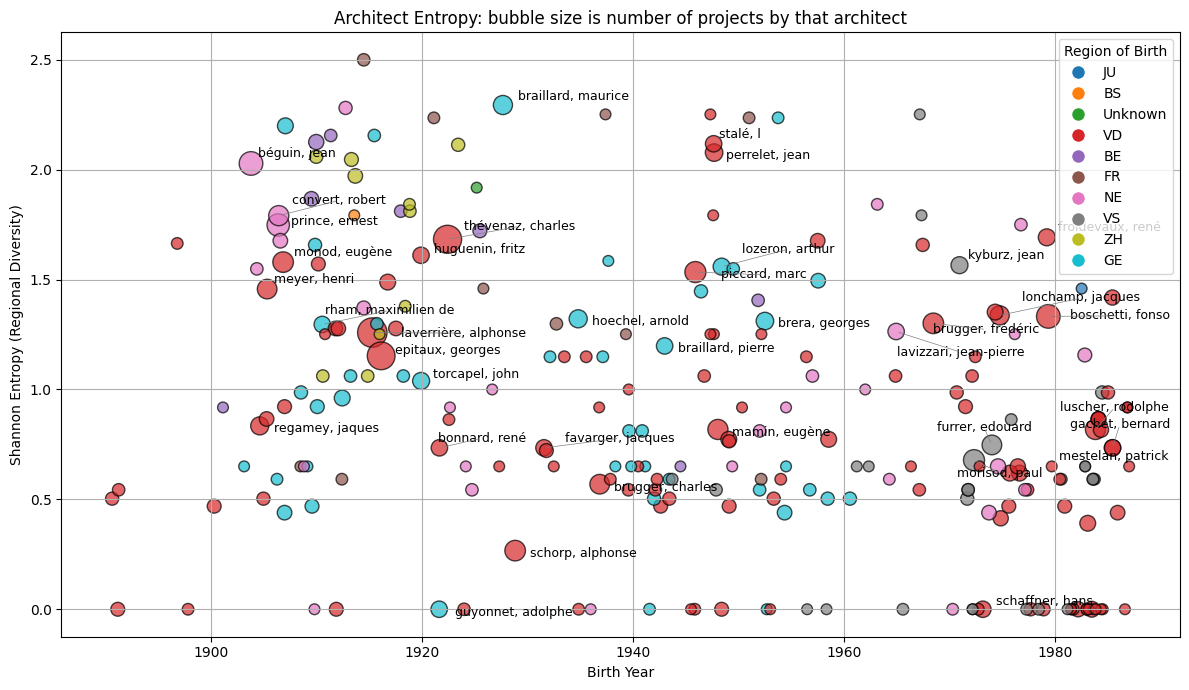

In [26]:
plot_entropy_vs_birth(authors_list)

In [20]:
ds[ds["Canton"].apply(lambda s: s if isinstance(s, str) else "unknown").str.startswith("& ")]

,orig_index,Nom de l'objet,Programme,Adresse 1,Adresse 2,Adresse 3,Numéro postal,Localité,Canton - Département,Pays,...,Dossiers reliés,Pièces reliées,CombinedArtists,is_jury,paired_competitons,comp_id,Commune,Canton,geo_loc,Auteurs_cleaned
83,301,Concours pour des abris de protection antiaéri...,None,None,None,None,NaN,None,None,None,...,None,None,"[[Gander, P], [Berthod, L.], [Forster, H, AG],...",True,[],301,& C:/Users/ASUS/AppData/Local/Programs/Python/...,& C:/Users/ASUS/AppData/Local/Programs/Python/...,None,"[Gander, P, Berthod, L., Forster, H, AG, Thürl..."


In [23]:
ds["Commune"].unique()

array(['Vevey', 'France', 'Genève', 'Le Locle', 'Neuchâtel', 'Lausanne',
       None, 'Yverdon-les-Bains', 'USA', 'Payerne', 'La Tour-de-Peilz',
       'Zürich', 'Bellinzona', 'Herisau', 'Czechia', 'Lauenen b. Gstaad',
       'Chancy', 'Basel', 'Colombier NE', 'Bern', 'Solothurn', 'Leysin',
       'Alle', 'Sion', 'Zofingen', 'Montreux', 'Fribourg', 'Biel/Bienne',
       'Belgique', 'Epesses', 'Schlieren', 'Ascona', 'Grenchen',
       '& C:/Users/ASUS/AppData/Local/Programs/Python/Python313/python.exe c:/Users/ASUS/Programmation/SwissArchitectureCompetitions/check_communes.py',
       'Caux', 'Cologny', 'Visp', 'Morges', 'Clarens', 'Orges',
       'Avenches', 'Bermgarten AG', 'Locarno', 'Pully', 'Hérémence',
       'Pregassona', 'La Chaux-de-Fonds', 'Echandens', 'Fiesch',
       'Chêne-Bourg', 'La Tour-de-Trême', 'Delémont', 'Lucens', 'Nyon',
       'Martigny', 'Japan', 'Riddes', 'Mission', 'Ettenhausen',
       'Liebefeld', 'Aigle', 'Wabern', 'Moudon', 'Italy', '', 'Gampel',
       'Li

In [24]:
ds["Canton"].unique()

array(['VD', 'France', 'GE', 'NE', None, 'USA', 'ZH', 'TI', 'AR',
       'Czechia', 'BE', 'BS', 'SO', 'Alle', 'VS', 'AG', 'FR', 'Belgique',
       '& C:/Users/ASUS/AppData/Local/Programs/Python/Python313/python.exe c:/Users/ASUS/Programmation/SwissArchitectureCompetitions/check_communes.py',
       'Bermgarten AG', 'JU', 'Japan', 'Ettenhausen', 'Italy', '', 'BL',
       'VVilleneuve VD', 'GR', 'GL', 'SZ', 'LU', 'Le Vaud', 'SH', 'Glis',
       'Tunisia', 'Bulgaria'], dtype=object)